# Subsumption Architecture

This notebook provides several python classes that allow you to simulate a Subsumption Architecture, first described by Rodney Brooks.

In [1]:
import aitk.robots
aitk.robots.__version__

'0.9.23'

In [2]:
import random

In [3]:
class SubsumptionBehavior(object):
    """
    Each subsumption behavior maintains it's own desired actuator values.
    Each behavior also maintains a flag. When this flag is True,
    the behavior wants to respond to the current situation. However, only
    the actuator values of the highest priority behavior will control the
    robot.
    
    The move method updates translate, rotate, and flag.
    The controller's add method updates robot and controller.
    """
    def __init__(self):
        self.translate = 0
        self.rotate = 0
        self.flag = False     
        self.robot = None      
        self.controller = None 
        
    def set_robot(self, robot):
        self.robot = robot
        
    def set_controller(self, controller):
        self.controller = controller

    def move(self, translate, rotate):
        self.flag = True
        self.translate = translate
        self.rotate = rotate
        
    def update(self):
        """
        Each behavior overrides this method to check whether it wants to control 
        the robot in the current situation.
        """
        pass

In [4]:
class SubsumptionController(object):
    """
    A SubsumptionBrain maintains a list of behaviors from lowest to
    highest priority.  On each time step, it determines the highest
    level behavior that wants to respond, and allows it to control the
    robot.
    """
    def __init__(self, robot):
        self.behaviors = []
        self.robot = robot
        self.prev_behavior = None
        self.robot.state["timer"] = 0 
        self.done = False
        
    def reset(self):
        """
        Reset key variables prior to each new run
        """
        self.prev_behavior = None
        self.robot.state["timer"] = 0 
        self.done = False

    def add(self, behavior):
        """
        Adds a behavior to the list of behaviors.
        """
        behavior.set_robot(self.robot)
        behavior.set_controller(self)
        self.behaviors.append(behavior)

    def step(self):
        """
        This method is called on every time step and determines the
        robot's action.
        """
        b = self.update_all()
        # check whether any of the behaviors have achieved the goal
        if self.done:
            self.robot.speak("Goal achieved!")
            return True
        curr_behavior = self.behaviors[b].__class__.__name__
        if curr_behavior != self.prev_behavior:
            self.robot.speak(curr_behavior)
            #print(curr_behavior, end=" ")
            self.prev_behavior = curr_behavior
        self.robot.move(self.behaviors[b].translate,self.behaviors[b].rotate)
    
    def update_all(self):
        """
        Returns the index of the highest priority behavior that wants
        to control the robot in the current situation.
        """
        # for all except lowest
        for b in range(len(self.behaviors) - 1, 0, -1):
            self.behaviors[b].flag = False
            self.behaviors[b].update()
            # if it fired, return number
            if self.behaviors[b].flag:
                return b
        # if none of the higher priority behaviors fired, return lowest
        self.behaviors[0].update()
        return 0

## Example: Find light

Implement several behaviors that when used together allow a robot to find a bulb in various worlds where the light is hidden behind walls. 

In [5]:
class Wander(SubsumptionBehavior):
    """
    Moves forward and randomly chooses a small rotation amount.
    """
    def update(self):
        self.move(.75, random.random() - 0.5)


In [6]:
class SeekLight(SubsumptionBehavior):
    """
    When light is sensed, moves forward slowly while turning towards
    the side which is sensing more light.
    """
    def update(self):
        left_light = self.robot["left-light"].get_brightness()
        right_light = self.robot["right-light"].get_brightness()
        diff_light = left_light - right_light
        if  max(left_light, right_light) > 0.0 and abs(diff_light) > 0.02:
            if diff_light < 0:
                # light stronger to right
                self.move(0.2, -0.1)
            else:
                # light stronger to left
                self.move(0.2, 0.1)

In [7]:
class Avoid(SubsumptionBehavior):
    """
    Turns away from obstacles. Uses a timer to repeatedly turn in the same direction
    to alleviate dithering in corners.
    """
    def update(self):
        left_ir = self.robot["left-ir"].get_distance()
        right_ir = self.robot["right-ir"].get_distance()
        if self.robot.state["timer"] > 0 or \
            left_ir < self.robot["left-ir"].get_max() or \
            right_ir < self.robot[1].get_max():
            if self.robot.state["timer"] == 0:
                self.robot.state["timer"] += 1
                if left_ir < right_ir:
                    # obstacle closer on left, rotate right
                    self.move(0.05, -0.4)
                else:
                    # obstacle closer on right, rotate left
                    self.move(0.05, 0.4)
            elif self.robot.state["timer"] > 5:
                self.robot.state["timer"] = 0
            else:
                # otherwise continue turning in the same direction as before
                self.robot.state["timer"] += 1
                self.move(self.translate, self.rotate)

In [8]:
class FoundLight(SubsumptionBehavior):
    """
    When the light sensed is above a certain threshold, stops the robot.
    """
    def update(self):
        left_light = self.robot["left-light"].get_brightness()
        right_light = self.robot["right-light"].get_brightness()
        total_light = left_light + right_light
        if total_light > 1.95:
            # goal achieved so tell controller to stop running
            self.move(0, 0)
            self.controller.done = True

In [9]:
world = aitk.robots.load_world("LightEnclosed")

Loading ./worlds/LightEnclosed.json...
Using random seed: 2121138


In [10]:
subsumption = SubsumptionController(world.robots[0])

In [11]:
# Uses 4 layered behaviors to find a light source, layers are added from lowest to highest priority

# Layer 0: By default robot will wander, moving forward and choosing random rotations
subsumption.add(Wander())

# Layer 1: If light is detected, then turn towards it
subsumption.add(SeekLight())

# Layer 2: When an obstacle is encountered, turn away from it
subsumption.add(Avoid())

# Layer 3: When the light readings are high enough, stop
subsumption.add(FoundLight())

In [12]:
def controller(robot):
    return subsumption.step()

In [13]:
world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [14]:
world.reset()
world.robots[0].set_random_pose()
subsumption.robot.set_max_trace_length(120)
subsumption.reset()
recorder = world.record()
world.seconds(120, [controller], real_time=False)

Using random seed: 2121138
Using random seed: 2121138
Simulation stopped at: 00:00:46.9; speed 102.7 x real time


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Player(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, continuous_update=False, description='Ti…

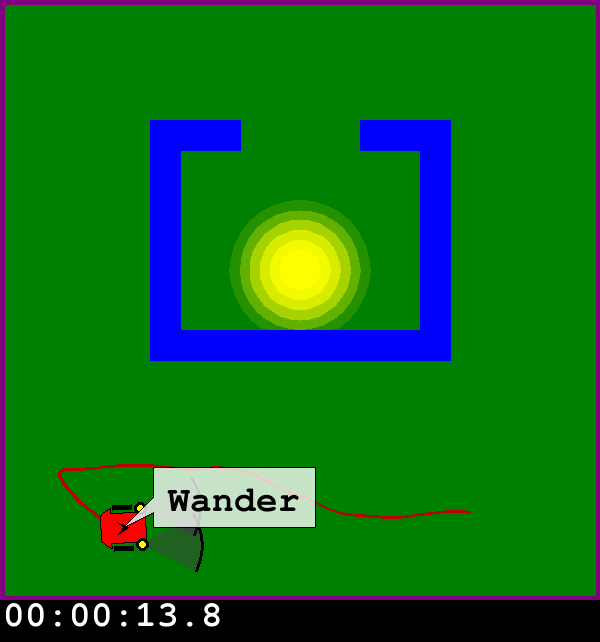

In [15]:
recorder.watch()